<a href="https://colab.research.google.com/github/alexisamachine/satellite_segmentation_model/blob/main/SatelliteImagerySegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [ ]:
!ls -lah '/content/drive/MyDrive/Colab Notebooks/DataSets/Satellite/'

ls: cannot access '/content/drive/MyDrive/Colab Notebooks/DataSets/Satellite/': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/DataSets/Satellite/'

In [ ]:
dataset_name = "DubaiDataset"

In [ ]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks':
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')):
        a = True
        #print(image_name)


G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 4\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 5\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 8\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 1\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 7\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 6\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 2\masks
G:\My Drive\Colab Notebooks\DataSets\Satellite\DubaiDataset\Tile 3\masks


In [8]:
image_patch_size = 256

In [9]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape[0]//image_patch_size

2

In [10]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [11]:
minmaxscaler = MinMaxScaler()

In [12]:
image_x = image_patches[0,0,:,:]
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [13]:
image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
  if image_type == 'images':
    image_extension = 'jpg' #png
  elif image_type == 'masks':
    image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:

        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size) * image_patch_size
        size_y = (image.shape[0]//image_patch_size) * image_patch_size

        image = Image.fromarray(image)
        image = image.crop((0,0,size_x, size_y))

        image = np.array(image)
        patched_images = patchify(image,(image_patch_size, image_patch_size, 3), step = image_patch_size)
        #print(len(patched_images))

        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [14]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [15]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

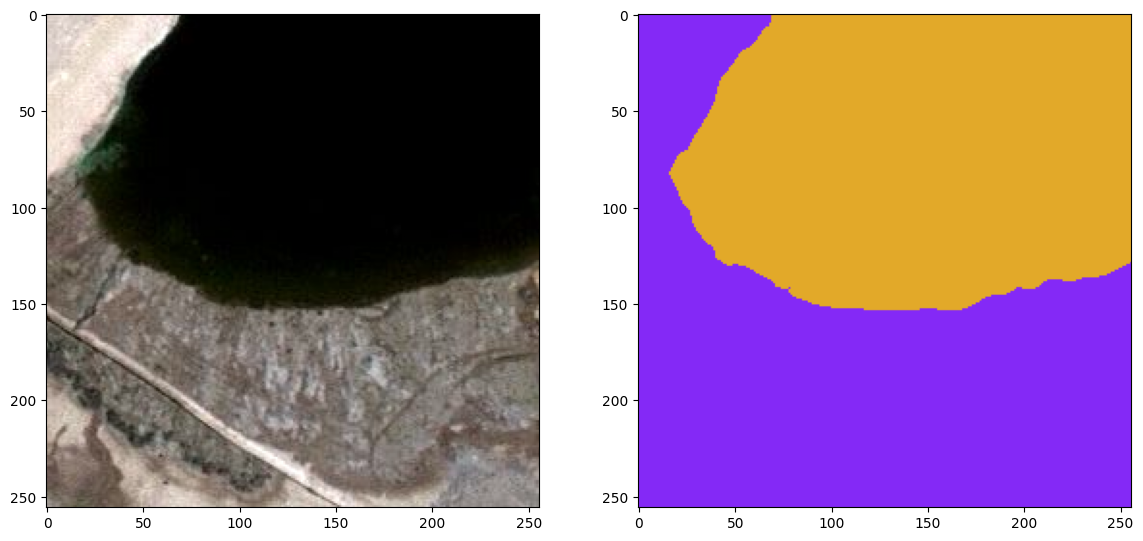

In [16]:
random_image_id = random.randint(0,len(image_dataset))
plt.figure(figsize = (14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
#plt.imshow(labels[random_image_id][:,:,0])

In [17]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16)for i in (0,2,4)))

In [18]:
class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16)for i in (0,2,4)))

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16)for i in (0,2,4)))

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16)for i in (0,2,4)))

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16)for i in (0,2,4)))

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16)for i in (0,2,4)))


In [19]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype= np.uint8)
  label_segment[np.all(label == class_water, axis = -1)] = 0
  label_segment[np.all(label == class_land, axis = -1)] = 1
  label_segment[np.all(label == class_road, axis = -1)] = 2
  label_segment[np.all(label == class_building, axis = -1)] = 3
  label_segment[np.all(label == class_vegetation, axis = -1)] = 4
  label_segment[np.all(label == class_unlabeled, axis = -1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [20]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [21]:
labels = np.array(labels)

In [22]:
labels = np.expand_dims(labels, axis = 3)

In [23]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

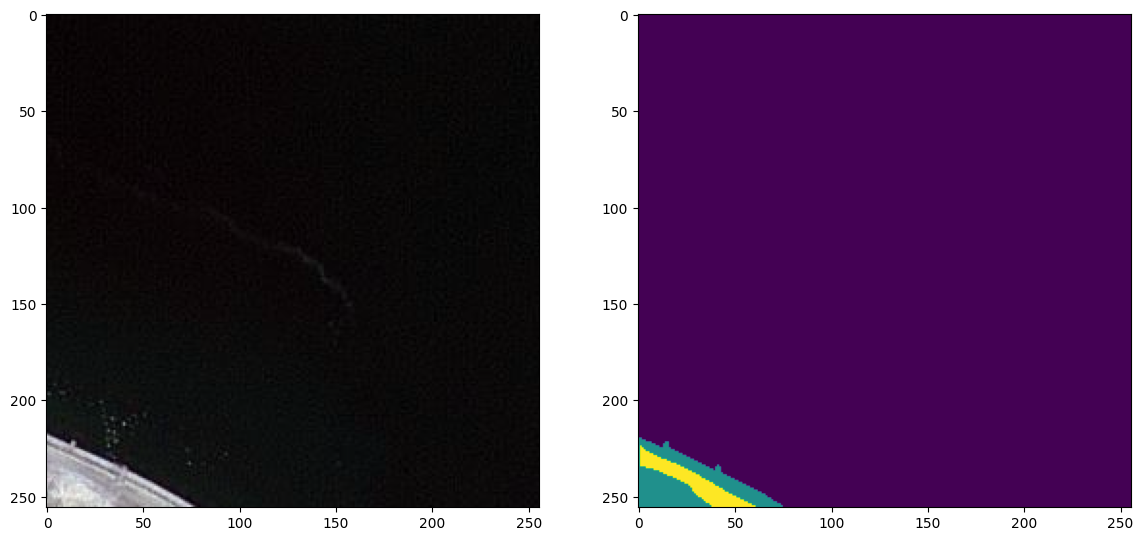

In [24]:
random_image_id = random.randint(0,len(image_dataset))
plt.figure(figsize = (14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [25]:
total_classes = len(np.unique(labels))

In [26]:
from tensorflow.keras.utils import to_categorical

In [27]:
labels_categorical_dataset = to_categorical(labels,num_classes=total_classes)

In [28]:
master_training_dataset = image_dataset

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [31]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
total_classes = y_train.shape[3]

PART II

In [32]:
!pip install -U segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [33]:
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [34]:
from keras import backend as K

In [35]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = intersection / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection)
  return final_coef_value

In [36]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channel = 1):
  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding = "same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(p4)
  c5= Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c5)

  u6 =Conv2DTranspose(128, (2,2), strides=(2,2), padding = "same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c6)

  u7 =Conv2DTranspose(64, (2,2), strides=(2,2), padding = "same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c7)

  u8 =Conv2DTranspose(32, (2,2), strides=(2,2), padding = "same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c8)

  u9 =Conv2DTranspose(64, (2,2), strides=(2,2), padding = "same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs = [inputs], outputs=[outputs])

  return model



In [37]:
metrics = ["accuracy", jaccard_coef]

In [38]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width = image_width,
                          image_channel=image_channels)

In [39]:
model = get_deep_learning_model()

generating loss function

In [40]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [41]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [42]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [43]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [44]:
total_loss = dice_loss + (1 * focal_loss)

model compilation

In [45]:
import tensorflow as tf

In [46]:
tf.keras.backend.clear_session()

In [47]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [48]:
model

In [49]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.13.0

Python 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
GPU is NOT AVAILABLE


In [50]:
model_history = model.fit(x_train, y_train,
                          batch_size=64,
                          verbose=1,
                          epochs=100,
                          validation_data=(x_test, y_test),
                          shuffle=False)

Epoch 1/100
13/13 [==============================] - 50s 1s/step - loss: 1.0062 - accuracy: 0.5155 - jaccard_coef: 0.2274 - val_loss: 0.9983 - val_accuracy: 0.5459 - val_jaccard_coef: 0.2214
Epoch 2/100
13/13 [==============================] - 2s 167ms/step - loss: 0.9964 - accuracy: 0.5824 - jaccard_coef: 0.2702 - val_loss: 0.9943 - val_accuracy: 0.5962 - val_jaccard_coef: 0.2430
Epoch 3/100
13/13 [==============================] - 2s 169ms/step - loss: 0.9925 - accuracy: 0.6361 - jaccard_coef: 0.2901 - val_loss: 0.9903 - val_accuracy: 0.6572 - val_jaccard_coef: 0.2777
Epoch 4/100
13/13 [==============================] - 2s 168ms/step - loss: 0.9889 - accuracy: 0.6711 - jaccard_coef: 0.3215 - val_loss: 0.9865 - val_accuracy: 0.6762 - val_jaccard_coef: 0.3007
Epoch 5/100
13/13 [==============================] - 2s 169ms/step - loss: 0.9833 - accuracy: 0.6589 - jaccard_coef: 0.3522 - val_loss: 0.9747 - val_accuracy: 0.6686 - val_jaccard_coef: 0.3473
Epoch 6/100
13/13 [==================

In [51]:
history_a = model_history

<function matplotlib.pyplot.show(close=None, block=None)>

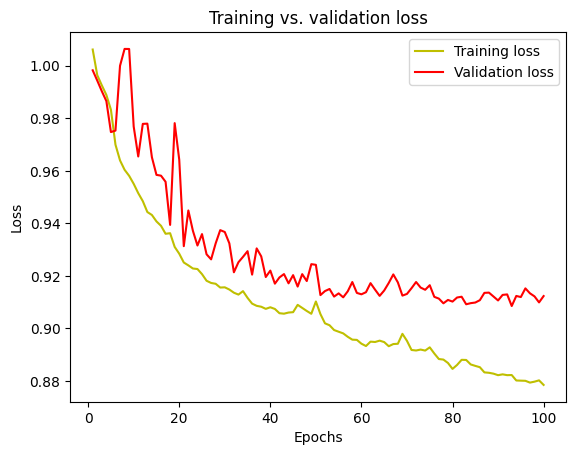

In [52]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training vs. validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

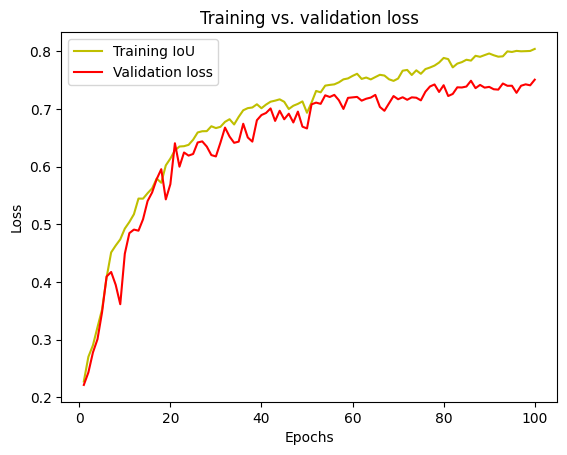

In [53]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label = "Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label='Validation loss')
plt.title("Training vs. validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [54]:
y_pred = model.predict(x_test)

5/5 [==============================] - 2s 18ms/step


In [ ]:
y_pred

In [60]:
y_pred_argmax = np.argmax(y_pred, axis = 3)

In [61]:
len(y_pred_argmax)

142

In [63]:
y_test_argmax = np.argmax(y_test, axis = 3)

comparing prediction results

In [95]:
#test_image_number = 4
test_image_number = random.randint(0,len(x_test))
test_image = x_test[test_image_number]

ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 23ms/step


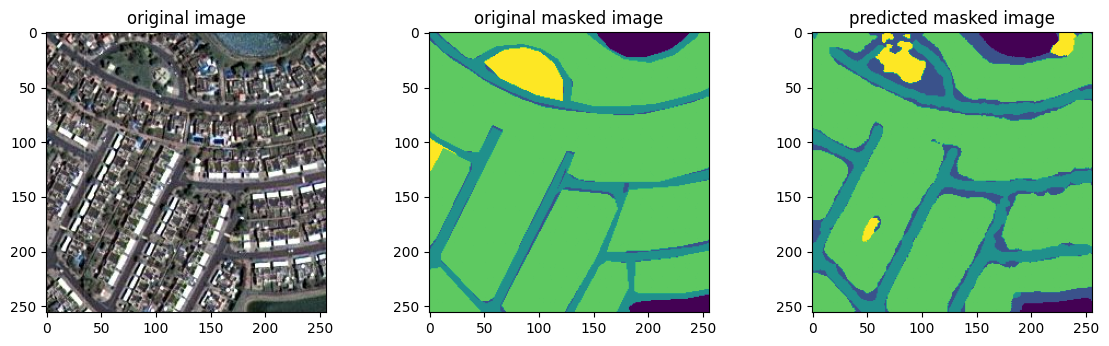

In [96]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("original image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("original masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("predicted masked image")
plt.imshow(predicted_image)


In [97]:
model.save("satellite_segmentation_full.h5")